In [ ]:
# https://www.kaggle.com/code/omaradel1221/lungandcoloncancerdetection-99

In [3]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


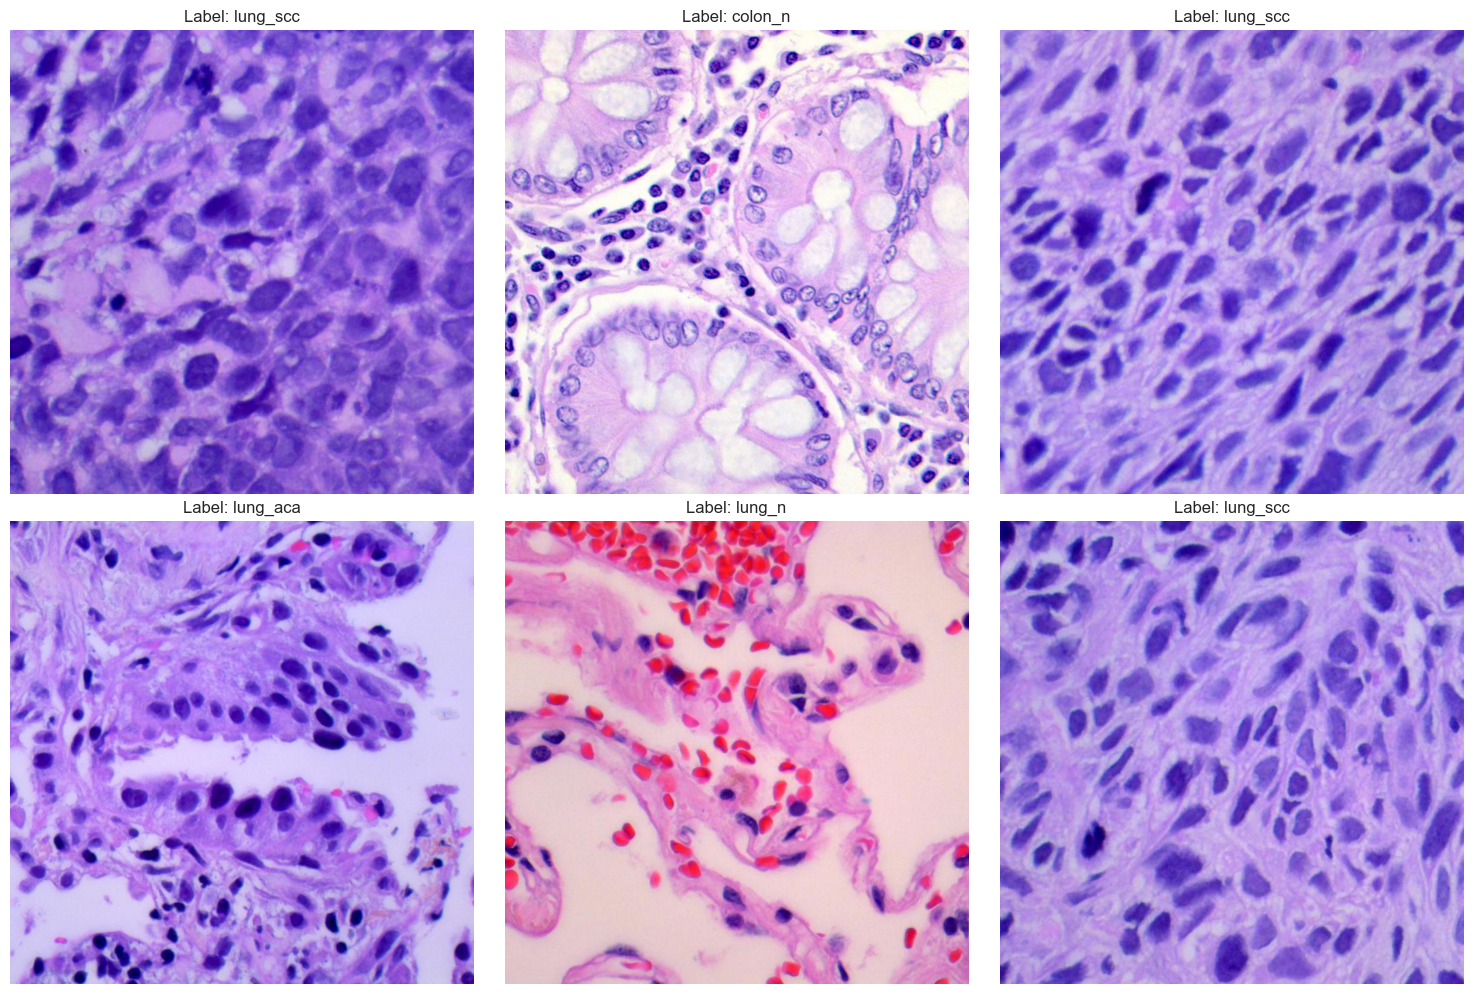

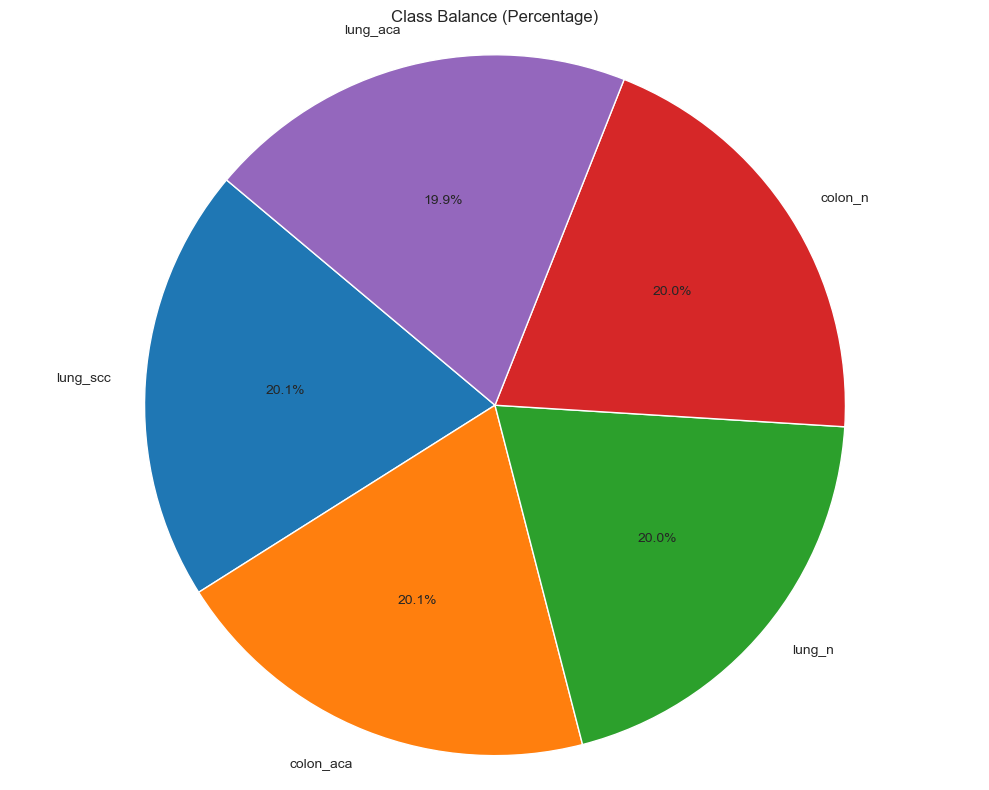

83683744/83683744 [==============================] - 106s 1us/step
Epoch 1/5
400/400 [==============================] - 318s 771ms/step - loss: 0.1425 - accuracy: 0.9537 - val_loss: 0.0221 - val_accuracy: 0.9900
Epoch 2/5
400/400 [==============================] - 210s 524ms/step - loss: 0.0365 - accuracy: 0.9869 - val_loss: 0.0063 - val_accuracy: 0.9968
Epoch 3/5
400/400 [==============================] - 211s 527ms/step - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 4/5
400/400 [==============================] - 211s 526ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 7.7644e-04 - val_accuracy: 0.9996
Epoch 5/5
50/50 [==============================] - 24s 479ms/step - loss: 6.5155e-04 - accuracy: 1.0000
Test Accuracy: 1.0


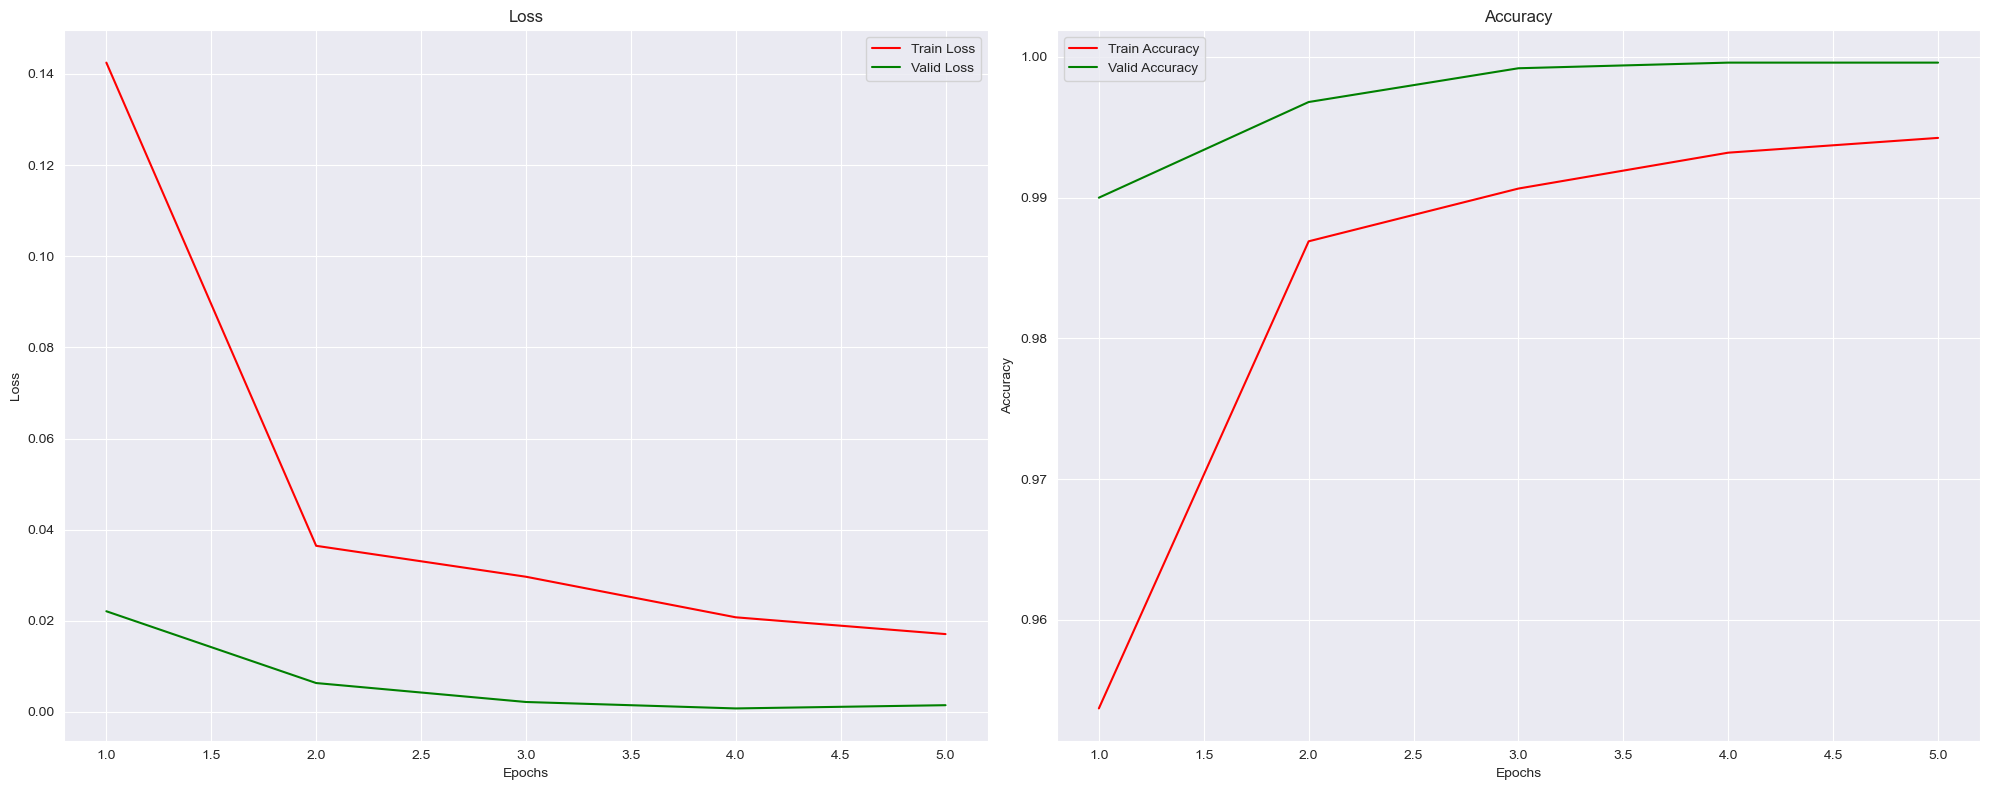

In [4]:

colon_data='E:/A__CVPR/Dataset/lung_colon_image_set/colon_image_sets'
lung_data='E:/A__CVPR/Dataset/lung_colon_image_set/lung_image_sets'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)
    
    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
lungDf= create_dataframe(lung_data)
colonDf=create_dataframe(colon_data)
################################################################ 
final_df = pd.concat([lungDf, colonDf], ignore_index=True)
final_df
################################################################
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(final_df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)
################################################################
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)
################################################################

import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)
################################################################
# Calculate class counts
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(train_df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()
################################################################
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
                                                     pooling = 'max' )

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(5 , activation= 'softmax' )
])
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 5 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )
################################################################

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
################################################################

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()



















